# 캡스톤 디자인 코드리뷰 6팀

## TadGAN을 이용한 택시 수요 분석

### 논문 : `TadGAN: Time Series Anomaly Detection Using Generative Adversarial Networks`
저자 : `Alexander Geiger, Dongyu Liu; Sarah Alnegheimish, Alfredo Cuesta-Infante, Kalyan Veeramachaneni`\
게재 저널명 : `IEEE International Conference on Big Data`\
예상 모델 학습 소요시간: `45분`\
컴퓨팅 성능 요구: `보통`\
소스코드 원본 주소: `https://github.com/sintel-dev/Orion/tree/master`

### 필요한 라이브러리

`{필요한 라이브러리 설치는 SSH 환경에서 실행하도록 권장합니다.}`

`요구 사항`
- tensorflow==2.15.0
- numpy=1.24.3 
- ml_dtypes==0.2.0
- pandas=1.5.3
- matplotlib=3.6.3
- scikit-learn=1.2.2
- scipy=1.10.1
- ipython=8.12.0
- tqdm==4.65.0
- similaritymeasures

`conda install과 pip install을 함께 사용할 경우 충돌이 발생할 수 있으므로 conda를 이용해 먼저 설치 후 conda에서 제공하지 않는 패키지의 경우 pip를 사용하여 설치할 것을 권장`


### 패키지 버전 및 설치 확인

`필요 라이브러리 설치 명령어`



가상환경이 활성화된 상태의 SSH에 순차적으로 입력
- `pip install numpy=1.24.3`
- `pip install ml_dtypes==0.2.0`
- `conda install pandas=1.5.3`
- `conda install matplotlib=3.6.3`
- `conda install scikit-learn=1.2.2`
- `conda install scipy=1.10.1`
- `conda install ipython=8.12.0`
- `pip install tqdm==4.65.0`
- `pip install similaritymeasures`



`주피터 노트북 환경에서 패키지 설치 여부 및 버전 확인`

In [ ]:
import skimage
print('skimage version',  skimage.__version__)
import tensorflow as tf
print('tensorflow version', tf.__version__)

skimage version 0.25.2
tensorflow version 2.19.0


---
# 데이터셋 준비

## 데이터셋 소개

### New York City Taxi Trip Duration

New York City Taxi Trip Duration 데이터셋은 2016년 뉴욕시 옐로우 택시의 운행 기록을 기반으로 하며 택시 승차 시점부터 하차 시점까지의 소요 시간을 예측하는 데 사용    
Kaggle에서 개최된 머신러닝 대회의 일환으로 제공

- 형식: CSV 파일
- 크기: 약 145만 개의 학습 샘플과 62만 개의 테스트 샘플
- 주요 목적: 주어진 정보로부터 택시 운행 시간(trip_duration)을 예측하는 회귀 문제 

`데이터셋의 여러 카테고리중 기간 별 이용 승객을 사용`

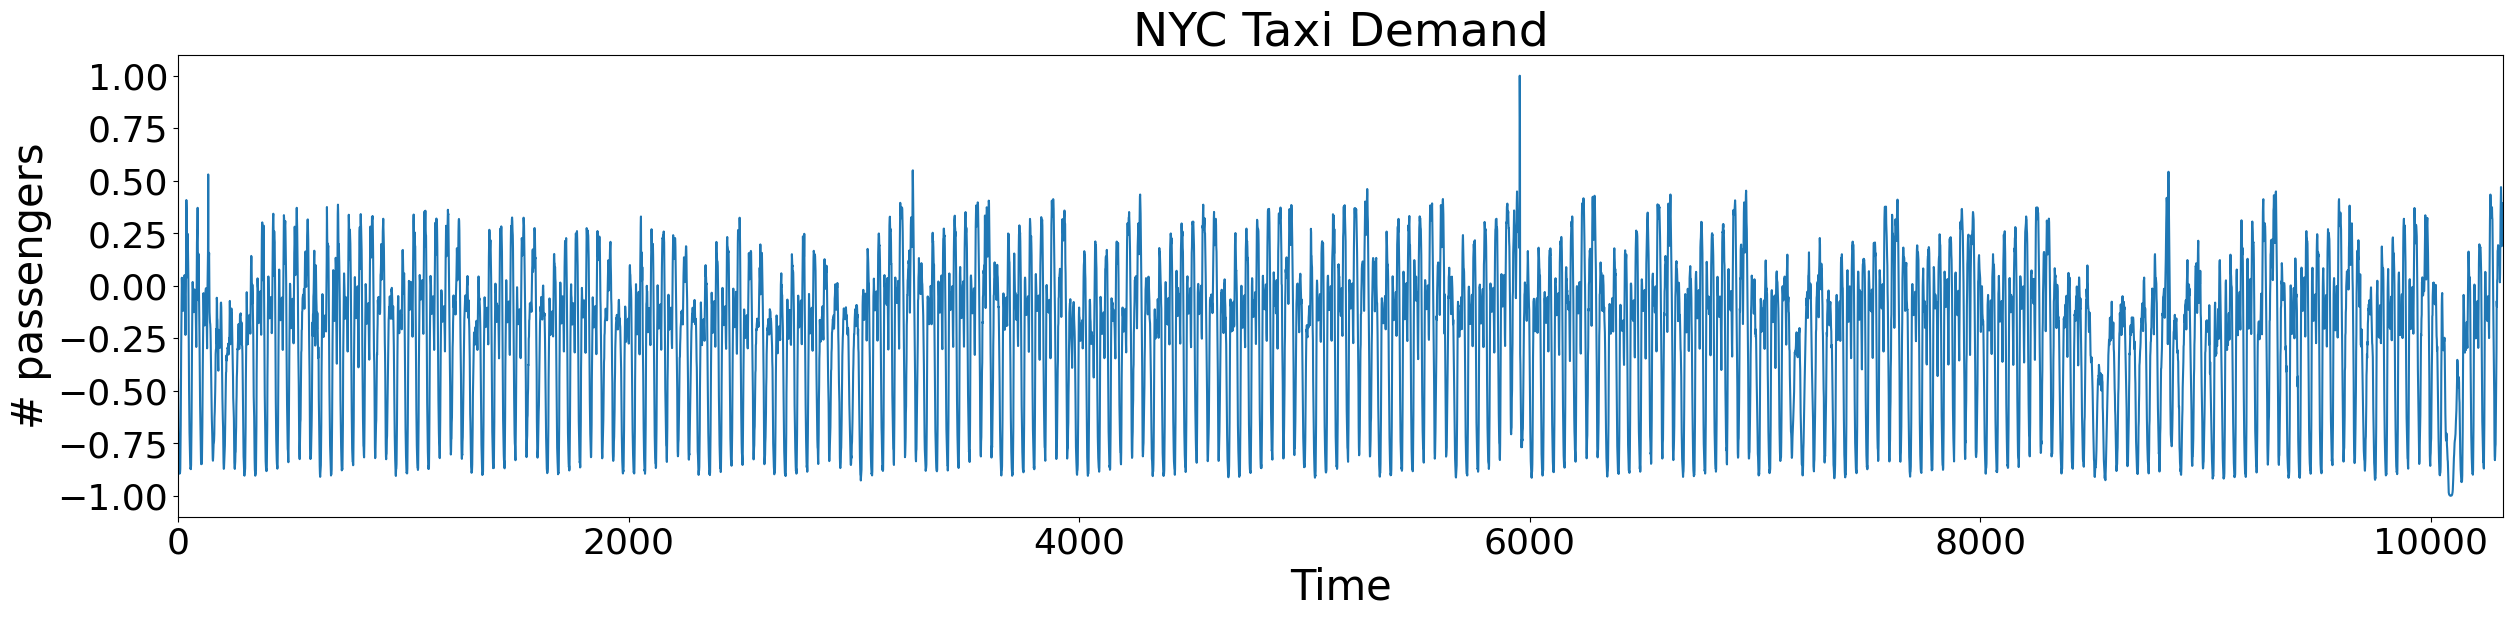
<center>NYC Taxi Demand</center>

## 유틸 함수 정의

##### 코드에 사용되는 다양한 유틸 함수 정의

`unroll_ts(y_hat)`
- 슬라이딩 윈도우 기반의 시계열 예측 결과를 원래 시계열로 재조합하는 함수
- 각 위치별 중첩 예측값을 중앙값(median)으로 통합하여 노이즈를 줄임

`convert_date(timelist)`, `convert_date_single(x)`
- UNIX timestamp를 datetime 객체로 변환하여 matplotlib 시각화 가능하게 함

`plot_ts(X, labels=None)`
- 단일 또는 다중 시계열을 선형 그래프로 시각화
- 예측값 vs 실제값을 한 눈에 비교 가능

`plot_error(X)`
- 여러 개의 예측/실제/오차 시계열을 층별로 분리하여 시각화

`plot(dfs, anomalies=[])`
- timestamp 기반 시계열 시각화
- 이상 탐지된 기간(시작~종료)을 배경 색으로 강조함

`plot_rws(X, window=100, k=5, lim=1000)`
- 여러 윈도우 구간을 슬라이드 방식으로 시각화

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

np.random.seed(0)

def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])

def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

def convert_date_single(x):
    return datetime.fromtimestamp(x)

def plot_ts(X, labels=None):
    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)
    
    if not isinstance(X, list):
        X = [X]
  
    for x in X:
        t = range(len(x))
        plt.plot(t, x)
    
    plt.title('NYC Taxi Demand', size=34)
    plt.ylabel('# passengers', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([t[0], t[-1]])
    
    if labels:
        plt.legend(labels=labels, loc=1, prop={'size': 26})
    
    plt.show()

def plot_error(X):
    plt.figure(figsize = (30, 6))
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.025, hspace=0.05) 

    i = 0
    for x in X:
        if len(x) == 2:
            ax1 = plt.subplot(gs1[i:i+2])
            for line in x:
                t = range(len(line))
                ax1.plot(t, line)
            i+=1
        else:
            ax1 = plt.subplot(gs1[i])
            t = range(len(line))
            ax1.plot(t, x, color='tab:red')

        i+=1
        plt.xlim(t[0], t[-1])
        plt.yticks(size=22)
        plt.axis('on')
        ax1.set_xticklabels([])

    plt.show()


def plot(dfs, anomalies=[]):
    
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    if not isinstance(anomalies, list):
        anomalies = [anomalies]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator() # every day

    month_fmt = mdates.DateFormatter('%b')

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['value'])

    colors = ['red'] + ['green'] * (len(anomalies) - 1)
    for i, anomaly in enumerate(anomalies):
        if not isinstance(anomaly, list):
            anomaly = list(anomaly[['start', 'end']].itertuples(index=False))
        
        for _, anom in enumerate(anomaly):
            t1 = convert_date_single(anom[0])
            t2 = convert_date_single(anom[1])
            plt.axvspan(t1, t2, color=colors[i], alpha=0.2)

    plt.title('NYC Taxi Demand', size=34)
    plt.ylabel('# passengers', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])

    # format xticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    
    # format yticks
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
    
    plt.show()
    
    
def plot_rws(X, window=100, k=5, lim=1000):
    shift = 75
    X = X[window:]
    t = range(len(X))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    
    num_figs = int(np.ceil(k / 5)) + 1
    fig = plt.figure(figsize=(15, num_figs * 2))
    
    j = 0
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
    
    j = 1
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    ax.set_yticklabels([])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
        
    for i in range(2, k):
        j = i * shift
        idx = t[j: window + j]
        
        ax = fig.add_subplot(num_figs, 5, i+1)
        ax.plot(idx, X[j], lw=2, color=colors[i+1])
        ax.set_yticklabels([])
        plt.title("window %d" % j, size=16)
        plt.ylim([-1, 1])
    
    plt.tight_layout()
    plt.show()

#### 필요한 라이브러리 임포트

In [2]:
# 기본 라이브러리 및 전처리 도구 불러오기
import sys
import numpy as np                    # 수치 계산용
import pandas as pd                   # 데이터프레임 처리용
import matplotlib.pyplot as plt       # 시각화용

# 결측치 처리 및 정규화 도구
from sklearn.impute import SimpleImputer         # 결측값 대체
from sklearn.preprocessing import MinMaxScaler   # 데이터 정규화 (0~1 사이)

### 데이터셋 압축 해제
다운 받은 데이터셋 압축 해제
> 데이터셋 용량이 커 10% 만 사용합니다

In [3]:
import zipfile
import os
import pandas as pd

# 1. 압축 해제
zip_path = 'tadgandataset.zip'
extract_dir = 'extracted_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 2. 모든 하위 폴더에서 nyc_taxi.csv 경로 찾기
csv_path = None
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        if file == 'nyc_taxi.csv':
            csv_path = os.path.join(root, file)
            break
    if csv_path:
        break

# 3. 경로 확인 후 읽기
if csv_path:
    df = pd.read_csv(csv_path)
    half_len = len(df) // 10 #데이터 용량이 커 데이터의 10%만 사용
    df = df.iloc[:half_len]
    print(df.head())
else:
    raise FileNotFoundError("nyc_taxi.csv 파일을 압축에서 찾을 수 없습니다.")

    timestamp    value
0  1404165600  10844.0
1  1404167400   8127.0
2  1404169200   6210.0
3  1404171000   4656.0
4  1404172800   3820.0


##### 데이터셋 확인

In [4]:
df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


## 데이터 전처리

##### 시계열 데이터를 고정 간격 단위로 집계(aggregation) 하는 유틸 함수

In [5]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    # numpy 배열일 경우 DataFrame으로 변환
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    # 시간 기준 정렬 후 인덱스 설정
    X = X.sort_values(time_column).set_index(time_column)
    # 단일 문자열 메서드인 경우 리스트로 변환
    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()

    # 시간 구간별로 데이터 집계
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)

In [6]:
# TimeSegments 
X, index = time_segments_aggregate(df, interval=1800, time_column='timestamp') # 30분 단위로 집계

#####  집계된 시계열 데이터 X에 존재할 수 있는 결측값(NaN) 처리

In [7]:
imp = SimpleImputer() # 기본 전략: 평균(mean)으로 결측치 대체
X = imp.fit_transform(X) # 결측값(NaN) → 해당 열의 평균값으로 채움

##### 시계열 데이터 X를 -1에서 1 사이로 정규화하여 TadGAN의 학습에 적합한 형태로 만듦

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))  # -1 ~ 1 범위로 정규화
X = scaler.fit_transform(X)

##### 시계열 데이터를 입력/타겟 시퀀스로 슬라이딩 윈도우 분할
딥러닝 기반 시계열 모델에서 시계열을 샘플 단위로 생성하는 핵심 단계

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):

    out_X = list() # 입력 시퀀스 저장 리스트
    out_y = list() # 타겟 시퀀스 저장 리스트
    X_index = list() # 입력 시퀀스의 시작 시간
    y_index = list() # 타겟 시퀀스의 시작 시간
    target = X[:, target_column]  # 예측할 대상 열

    # 결측값 포함 시퀀스를 제거할지 여부
    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        # drop 조건을 만족하면 해당 구간 skip
        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

##### 정제된 시계열 데이터를 딥러닝 모델 학습에 적합한 입력/타겟 쌍으로 슬라이딩 윈도우 방식으로 분할
나눠진 시퀀스는 TadGAN 학습뿐 아니라 일반 LSTM 예측이나 재구성 기반 이상 탐지에도 사용할 수 있는 기본 시계열 입력 형태를 구성

In [10]:
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, # 입력 시퀀스 길이: 100개 타임스텝
                                                  target_size=1, # 예측할 시점 수: 1개
                                                  step_size=1, # 1 스텝씩 슬라이딩
                                                  target_column=0) # 예측 대상 컬럼: 첫 번째 열

##### `rolling_window_sequences` 함수를 통해 생성된 학습 데이터를 형상(Shape) 기준으로 확인
- X.shape: 총 7891개의 샘플, 각 샘플은 길이 100의 시계열 (1차원 특성)
- X_index.shape: 각 샘플의 시작 타임스탬프
- y.shape: 각 샘플에 대한 타겟 값 (1-step ahead)
- y_index.shape: 타겟 값의 시점 (예측하고자 하는 시간)

In [11]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))


Training data input shape: (932, 100, 1)
Training data index shape: (932,)
Training y shape: (932, 1)
Training y index shape: (932,)


# 모델 구축

TadGAN을 위한 GPU 확인    
> GPU : 0 이어도 정상입니다.

In [12]:
# GPU 확인

import tensorflow as tf
import logging
import math

gpus = tf.config.experimental.list_physical_devices('GPU') 
if gpus: 
    try: 
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True) 
    except RuntimeError as e: 
        print(e)
print (gpus)

2025-05-02 05:20:45.461289: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 05:20:48.098964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 05:20:48.099115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 05:20:48.381468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 05:20:49.040262: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


로거(Logger) 객체 생성    
- 로거는 학습 중 발생하는 메시지(예: 학습 시작/종료, 에폭 진행 상황, 오류 등)를 표준화된 방식으로 출력하는 기능

In [13]:
LOGGER = logging.getLogger(__name__)

## 필요한 모듈 로드

### 라이브러리 설명<br/>

- `numpy, pandas` : 수치 연산과 데이터프레임 조작용 기본 패키지    
<br/>
- `pickle` : 학습 결과나 설정을 저장/불러오는 데 사용    
<br/>
- `matplotlib.pyplot` : 시각화를 위한 그래프 그리기    
<br/>
- `similaritymeasures` : 원래와 재구성된 시계열 간의 유사도 측정 (예: DTW, area difference 등)    
<br/>
- `tensorflow.keras.*` : GAN 모델 구현을 위한 핵심 구성 요소들 (모델, 레이어, 옵티마이저 등)    
<br/>
- `CuDNNLSTM` : GPU 가속화된 LSTM 레이어 (성능 향상용)    
<br/>
- `functools.partial` : 함수를 고정된 파라미터로 래핑하여 사용할 수 있도록 지원    
<br/>
- `scipy.integrate, scipy.stats` : 수치 적분 및 통계적 계산 수행 (예: area difference 계산 등)    



In [14]:
import numpy as np
import pandas as pd
import pickle

import keras
import matplotlib.pyplot as plt

import similaritymeasures as sm
from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense, Reshape, UpSampling1D, TimeDistributed
from tensorflow.keras.layers import Activation, Conv1D, LeakyReLU, Dropout, Add, Layer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM as CUDNNLSTM
from tensorflow.keras.optimizers import Adam

from functools import partial
from scipy import integrate, stats

### 모델 정의

##### RandomWeightedAverage 레이어 정의
- RandomWeightedAverage 레이어는 real 샘플과 generated 샘플 사이의 랜덤 가중 평균을 생성하여 gradient penalty를 계산하는 데 사용    
- TadGAN은 Wasserstein GAN의 변형을 사용하므로 이 과정은 Critic 네트워크 학습의 핵심

In [15]:
# Wasserstein GAN의 gradient penalty 계산을 위한 커스텀 레이어

class RandomWeightedAverage(Layer):
    def _merge_function(self, inputs):
        alpha = K.random_uniform((64, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

##### TadGAN 인코더 정의
- TadGAN에서 시계열 데이터를 잠재 공간(latent space)으로 인코딩하기 위한 Encoder 모델을 생성
- 논문에서는 이 네트워크를 E : X → Z 로 정의하며 이는 입력 시계열을 잠재 벡터로 매핑하는 함수

In [16]:
def build_encoder_layer(input_shape, encoder_reshape_shape):    
    # 입력 레이어 정의
    input_layer = layers.Input(shape=input_shape)

    # 양방향 CuDNN LSTM (시계열의 과거와 미래 정보를 모두 활용)
    x = layers.Bidirectional(CUDNNLSTM(units=100, return_sequences=True))(input_layer)
    
    # LSTM 출력을 1D 벡터로 변환
    x = layers.Flatten()(x)
    
    # Dense layer를 통해 잠재 벡터 크기를 20차원으로 압축
    x = layers.Dense(20)(x)
    
    # 원하는 잠재 벡터 형태로 reshape (e.g. (10, 2))
    x = layers.Reshape(target_shape=encoder_reshape_shape)(x)
    
    # 모델 생성 (입력 → 잠재 표현)
    model = keras.models.Model(input_layer, x, name='encoder')
    
    return model

##### TadGAN Generator 정의
- 잠재 벡터 z를 입력 받아 LSTM 기반 네트워크를 통해 시계열 데이터로 복원
- G : Z → X에 해당하며 인코더(E)의 출력이나 랜덤 latent 벡터를 시계열로 재생성하는 데 사용

In [17]:
def build_generator_layer(input_shape, generator_reshape_shape):
    
    # 입력 레이어 정의 (잠재 공간 벡터 입력)
    input_layer = layers.Input(shape=input_shape)
    
    # 입력 벡터를 평탄화
    x = layers.Flatten()(input_layer)

    # 시퀀스 길이에 맞게 차원 확장
    x = layers.Dense(generator_reshape_shape[0])(x)

    # 재구성된 형태로 reshape (ex. (timesteps, features))
    x = layers.Reshape(target_shape=generator_reshape_shape)(x)

    # 양방향 LSTM (64 units × 2), 시계열 처리
    x = layers.Bidirectional(CUDNNLSTM(units=64, return_sequences=True), merge_mode='concat')(x)

    # 시퀀스 길이 2배 업샘플링
    x = layers.UpSampling1D(size=2)(x)

    # 추가 양방향 LSTM 적용
    x = layers.Bidirectional(CUDNNLSTM(units=64, return_sequences=True), merge_mode='concat')(x)

    # 각 시점별 출력값을 1차원으로 압축
    x = layers.TimeDistributed(layers.Dense(1))(x)

    # 출력값을 tanh 함수로 정규화 (-1 ~ 1)
    x = layers.Activation(activation='tanh')(x)

    # 모델 정의
    model = keras.models.Model(input_layer, x, name='generator')
    
    return model

##### TadGAN Critic X 정의

- Critic X는 시계열 데이터(real 또는 fake)를 입력으로 받아 얼마나 실제와 유사한지 판단하는 판별자(discriminator) 역할
- 여러 층의 Conv1D와 LeakyReLU를 쌓아 시계열의 패턴을 학습하며 마지막 Dense 레이어는 Wasserstein score를 출력

In [18]:
def build_critic_x_layer(input_shape):
    
    input_layer = layers.Input(shape=input_shape)

    # 1D Convolution + LeakyReLU + Dropout 조합을 반복하여 시계열 특징 추출
    x = layers.Conv1D(filters=64, kernel_size=5)(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)

    # 특징을 1차원 벡터로 변환 후, 판별 점수 출력
    x = layers.Flatten()(x)
    x = layers.Dense(units=1)(x)

    model = keras.models.Model(input_layer, x, name='critic_x')
    
    return model

##### TadGAN Critic Z 정의
- TadGAN의 두 번째 판별자 역할
- 잠재 공간 Z 상의 벡터가 실제로 인코더 E(x)에 의해 생성된 것인지 아니면 단순히 정규분포에서 무작위로 샘플링된 것인지를 구분

In [19]:
def build_critic_z_layer(input_shape):
    
    input_layer = layers.Input(shape=input_shape)

    # 잠재 벡터 z를 1차원 벡터로 변환
    x = layers.Flatten()(input_layer)

    # Fully connected layers로 비선형 변환 및 특징 추출
    x = layers.Dense(units=100)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)    

    x = layers.Dense(units=100)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)  

    # Wasserstein score 출력 (real vs fake 판별 점수)
    x = layers.Dense(units=1)(x)

    model = keras.models.Model(input_layer, x, name='critic_z')
    
    return model

##### Wasserstein GAN (WGAN)에서 사용하는 손실 함수
- 기존의 GAN에서 사용하던 binary cross-entropy 대신 WGAN은 실수 기반의 차이를 계산하여 더 안정적인 학습이 가능

In [20]:
def wasserstein_loss(y_true, y_pred):
    # Wasserstein loss는 정답 y_true(1 또는 -1)와 예측값 y_pred의 곱의 평균을 반환
    return K.mean(y_true * y_pred)

입력 시계열 데이터를 모델에 학습시키기 위해 고정된 길이의 서브시퀀스(sub-sequence)로 나눔

In [21]:
window_size = 100  # 시계열을 분할할 슬라이딩 윈도우의 크기

##### TadGAN을 구성하는 네트워크들의 입출력 형태를 정의
- 각 서브 모델(Encoder, Generator, Critic X, Critic Z)을 생성하며 최적화에 사용할 Adam Optimizer를 초기화
- 각 모델별 옵티마이저를 따로 설정하는 것은 훈련 단계에서 각 네트워크를 개별적으로 업데이트하기 위함

In [22]:
# Layer Parameters
encoder_input_shape = (window_size, 1)          # 인코더 입력: 시계열 구간 (길이 100, 1차원)
generator_input_shape = (20, 1)                 # 생성기 입력: 잠재 공간 벡터 z

critic_x_input_shape = (window_size, 1)         # Critic X 입력: 시계열 구간
critic_z_input_shape = (20,1)                   # Critic Z 입력: 잠재 벡터

encoder_reshape_shape = (20, 1)                 # 인코더 출력 형태 (잠재 공간 벡터)
generator_reshape_shape = (window_size//2, 1)   # 생성기 내부 업샘플링 전 중간 시퀀스 형태

learning_rate = 0.0005                          # 모든 Optimizer에 사용할 학습률

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

# 각 모델별로 개별 옵티마이저 설정 (Adam 사용)
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

2025-05-02 05:30:28.991684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79272 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0


##### Encoder의 구조
- 입력: 시계열 데이터 (Trace)
- 출력: 잠재 표현 (Latent Vector)
- 역할: X → Z

In [23]:
encoder.summary() # Trace를 입력으로 받아 Latent Vector 생성

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 bidirectional (Bidirection  (None, 100, 200)          82400     
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 20)                400020    
                                                                 
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
Total params: 482420 (1.84 MB)
Trainable params: 482420 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

##### Generator의 구조
- 입력: 잠재 벡터 Z
- 출력: 재구성된 시계열
- 역할: Z → X̂

In [24]:
generator.summary() # Latent Vector 로 부터 유사한 Trace를 생성 

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 reshape_1 (Reshape)         (None, 50, 1)             0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 128)           34304     
 onal)                                                           
                                                                 
 up_sampling1d (UpSampling1  (None, 100, 128)          0         
 D)                                                      

##### Critic X의 구조

- 입력: 실제 시계열 또는 Generator의 출력
- 출력: 실재성(score)
- 역할: X가 진짜인지 판별

In [25]:
critic_x.summary() # Original input X 에 대한 감시 

Model: "critic_x"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            384       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 64)            0         
                                                                 
 dropout (Dropout)           (None, 96, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            20544     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 92, 64)            0         
                                                                 
 dropout_1 (Dropout)         (None, 92, 64)            0  

##### Critic Z의 구조
- 입력: Encoder가 생성한 z 또는 무작위 z
- 출력: 자연스러운 분포인지 판단
- 역할: Z가 진짜인지 판별

In [26]:
critic_z.summary()  # Generated 되는 것에 대한 감시

Model: "critic_z"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 100)               2100      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 100)               0  

- latent_dim은 TadGAN의 인코더가 시계열을 변환할 잠재 벡터의 크기를 정의
- shape은 모델 입력으로 들어가는 시계열 조각의 기본 형태

In [27]:
latent_dim = 20               # 잠재 공간(latent space)의 차원 수
shape = (window_size, 1)      # 입력 시계열의 기본 형태 (길이 100, 단일 특성)

### 필요 함수 정의

##### TadGAN의 Critic X를 1 batch만큼 학습시키는 함수
- real 시계열 x와 generator가 생성한 fake x를 구분하도록 Critic X를 훈련
- Wasserstein loss: 실제 샘플은 -1, 생성된 샘플은 +1을 곱해 loss를 계산
- Gradient penalty: 보간된 입력(interpolated)에서 gradient의 norm이 1에 가까워지도록 손실에 패널티를 추가. (WGAN-GP의 핵심 안정화 기법)
- @tf.function: TensorFlow 그래프로 변환하여 학습 성능을 높임

In [28]:
@tf.function
def critic_x_train_on_batch(x, z):
    # Critic X 학습 함수: real 시계열 x vs. fake 시계열 generator(z)를 비교해 판별자 학습
    with tf.GradientTape() as tape:
        
        valid_x = critic_x(x)           # real 시계열에 대한 판별자 출력
        x_ = generator(z)               # 잠재벡터 z로부터 시계열 생성
        fake_x = critic_x(x_)           # fake 시계열에 대한 판별자 출력
        
        # Gradient Penalty 계산을 위한 보간(interpolation) 샘플 생성
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_ 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)  # 보간 샘플에 대한 판별자 출력
        
        grads = gp_tape.gradient(pred, interpolated)  # gradient 계산
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)  # L2 norm
        gp_loss = 10.0 * tf.reduce_mean(tf.square(grad_norm - 1.0))  # gradient penalty (λ=10)
                
        # Wasserstein loss: real은 -1, fake는 +1을 곱함
        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        
        # 총 손실: W-loss(real) + W-loss(fake) + gradient penalty
        loss = loss1 + loss2 + gp_loss
                        
    # Critic X에 대해 역전파 및 최적화 수행
    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    
    return loss

##### TadGAN의 Critic Z 네트워크를 1배치 학습시키는 함수
- Critic Z는 잠재공간 Z 상에서 진짜 z (정규분포에서 샘플링된 것) 와 가짜 z (인코더가 만든 것) 을 구별하도록 학습
- 진짜 z와 인코더가 만든 z_를 Critic Z가 평가
- 중간 값을 보간한 샘플을 통해 gradient penalty 적용
- WGAN-GP 손실로 Critic Z 업데이트 → Z 공간의 학습 안정화에 기여

In [29]:
@tf.function
def critic_z_train_on_batch(x, z):
    
    with tf.GradientTape() as tape:

        z_ = encoder(x)                   # 입력 시계열 x를 인코딩하여 잠재 벡터 z_ 생성
        valid_z = critic_z(z)             # 실제 latent vector z에 대한 판별 결과
        fake_z = critic_z(z_)             # 인코더가 만든 z_에 대한 판별 결과 (분포 유사 여부 판단)
        
        # 보간(interpolation) 샘플 생성
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_
                
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
            
        # Gradient Penalty 계산
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0 * tf.reduce_mean(tf.square(grad_norm - 1.0))
        
        # Wasserstein Loss 계산
        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)    # real z는 -1로 학습
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z)       # fake z_는 +1로 학습
        loss = loss1 + loss2 + gp_loss

    # Critic Z에 대한 경사하강 및 파라미터 업데이트
    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    
    return loss

##### Encoder와 Generator를 함께 훈련
##### `Encoder 학습 목표`
- E(x)로 얻은 z가 실제 분포처럼 보이게 함 (Critic Z 속이기)
- G(E(x))가 원래 x와 비슷하도록 복원 (재구성 손실 최소화)
- G(z)가 진짜 시계열처럼 보이게 함 (Critic X 속이기)
##### `Generator 학습 목표`
- 랜덤 z → G(z)가 진짜처럼 보이게
- G(E(x))가 x를 잘 복원하게
- Critic X, Z 둘 다 속이도록 학습

In [30]:
@tf.function
def enc_gen_train_on_batch(x, z):
    
    # ---------- Encoder 학습 ----------
    with tf.GradientTape() as enc_tape:
        z_gen_ = encoder(x, training=True)              # x를 잠재 벡터로 인코딩
        x_gen_ = generator(z, training=False)           # 무작위 z로부터 생성된 시계열
        x_gen_rec = generator(z_gen_, training=False)   # 인코딩된 z로부터 재구성된 시계열

        fake_gen_x = critic_x(x_gen_, training=False)   # Critic X가 생성된 x를 판별
        fake_gen_z = critic_z(z_gen_, training=False)   # Critic Z가 생성된 z를 판별

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))  # 생성된 x가 진짜처럼 보이도록
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))  # 인코딩된 z가 진짜처럼 보이도록
        loss3 = 10.0 * tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec)) # 원본 x와 복원된 x의 재구성 오차

        enc_loss = loss1 + loss2 + loss3

    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    # ---------- Generator 학습 ----------
    with tf.GradientTape() as gen_tape:
        z_gen_ = encoder(x, training=False)             # 인코딩된 z
        x_gen_ = generator(z, training=True)            # 무작위 z → x 생성
        x_gen_rec = generator(z_gen_, training=True)    # 인코딩된 z → x 재생성

        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0 * tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3

    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    

    return enc_loss, gen_loss

## 모델 학습

### 하이퍼파라미터 설정

In [31]:
batch_size = 64     # 학습 시 한 번에 처리할 시계열 윈도우 수
n_critics = 5       # Generator/Encoder 1회 학습 전에 Critic을 5회 학습 (WGAN 관례)
epochs = 100        # 전체 학습 반복 횟수

 변수 X에 저장된 입력 시계열 데이터의 차원(shape)을 확인

In [32]:
X.shape

(932, 100, 1)

TensorFlow의 실행 모드를 즉시 실행(eager execution)으로 강제    
@tf.function 함수를 사용해 한 줄씩 디버깅 가능한 형태로 실행    
함수 내부에서 값이 이상하거나 오류가 발생할 때 디버깅을 쉽게 하기 위해

In [33]:
tf.config.experimental_run_functions_eagerly(True) # @tf.function 데코레이터가 붙은 함수도 즉시 실행(eager mode)되도록 설정

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


시계열 데이터를 TadGAN 모델이 학습 가능한 형태로 전처리    
- `X.reshape((-1, shape[0], 1))` 전체 데이터를 window_size 단위로 잘라서 3차원 형태로 변환    
- `X_ = np.copy(X)` 나중에 예측 결과와 비교하거나 원본을 유지하기 위해 복사본을 만들어둠

In [34]:
X = X.reshape((-1, shape[0], 1)) # 시계열 데이터를 (샘플 수, window_size, 1) 형태로 변형
X_ = np.copy(X) # 원본 데이터를 보존하기 위한 복사본 생성

### 모델 학습
1. Critic 먼저 학습 (WGAN-GP 전략)
- Critic X: 시계열 x가 real인지 fake인지 판단하도록 학습
- Critic Z: 잠재 벡터 z가 진짜 분포에서 왔는지 구별하도록 학습
- n_critics만큼 반복해 판별자 학습을 우선시함 (Generator 학습 전 안정화)

2. Generator & Encoder 학습
- 목표: fake 시계열과 fake latent가 real처럼 보이도록 Critic을 속이는 것
- x → E(x) → G(E(x)) ≈ x 구조에서 **재구성 오류(MSE)**도 같이 최소화함

3. 손실 기록 및 모니터링
- 각 손실을 평균내어 Epoch별 학습 상태를 콘솔에 출력
- 손실 변화 추이를 통해 학습 수렴 여부 확인 가능    


TadGAN의 핵심 학습 메커니즘을 충실히 따르며 특히 WGAN-GP의 안정성과 cycle consistency를 모두 반영한 구조

In [35]:
# 초기화: 손실 기록용 리스트
epoch_e_loss = []    # Encoder loss 기록
epoch_g_loss = []    # Generator loss 기록
epoch_cx_loss = []   # Critic X loss 기록
epoch_cz_loss = []   # Critic Z loss 기록

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)  # 매 epoch마다 데이터 순서를 섞음
    
    minibatches_size = batch_size * n_critics   # 한 iteration에 사용될 전체 샘플 수 (e.g. 64×5=320)
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 반복 횟수 계산
    
    encoder.trainable = False
    generator.trainable = False
    
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
                
        # Critic X와 Critic Z를 n_critics 횟수만큼 먼저 학습
        for j in range(n_critics):
            
            x = minibatch[j * batch_size: (j + 1) * batch_size]  # 실제 시계열 데이터
            # 정규분포에서 샘플링한 latent vector
            z = tf.random.normal(shape=(batch_size, latent_dim, 1), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)
            
            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))  # Critic X 업데이트
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))  # Critic Z 업데이트
        
        # Generator & Encoder 학습
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True
        
        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)  # Generator & Encoder 공동 학습
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)

    # epoch별 평균 손실 계산    
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))    

2025-05-02 05:34:11.456764: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Epoch: 1/100, [Dx loss: 6.7483086585998535] [Dz loss: 1.2295022010803223] [E loss: 2.1413204669952393] [G loss: 1.9512403011322021]
Epoch: 2/100, [Dx loss: 3.446171283721924] [Dz loss: 0.8671380877494812] [E loss: 1.652099609375] [G loss: 1.3448371887207031]
Epoch: 3/100, [Dx loss: 1.7266026735305786] [Dz loss: 0.9235101342201233] [E loss: 1.0927287340164185] [G loss: 0.678577184677124]
Epoch: 4/100, [Dx loss: 0.684472382068634] [Dz loss: 1.1466327905654907] [E loss: 0.5707839131355286] [G loss: 0.07854318618774414]
Epoch: 5/100, [Dx loss: 0.0250832699239254] [Dz loss: 1.467825174331665] [E loss: 0.11382238566875458] [G loss: -0.45016956329345703]
Epoch: 6/100, [Dx loss: -0.3928975462913513] [Dz loss: 1.7346068620681763] [E loss: -0.19465118646621704] [G loss: -0.7893752455711365]
Epoch: 7/100, [Dx loss: -0.678801953792572] [Dz loss: 1.6509240865707397] [E loss: 0.10334412008523941] [G loss: -0.4983500838279724]
Epoch: 8/100, [Dx loss: -0.8873761296272278] [Dz loss: 1.0358798503875732]

# 모델 실험 결과

## 학습된 TadGAN 모델을 사용하여 새로운 시계열 데이터에 대해 이상 탐지(inference)를 수행 및 시각화
1. 시계열을 슬라이딩 윈도우로 분할
2. 정규화(MinMaxScaler)를 적용해 학습 환경과 동일하게 맞춤
3. Generator로 복원된 시계열과 실제 시계열의 차이(오차)를 기반으로 이상 점수 계산
4. 상위 5%의 복원 오차를 가진 시점들을 이상치로 판단
5. 시각화 함수들을 통해 결과를 시계열 및 스코어 차트로 표현

/home/elicer/miniconda3/envs/tadgan/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 1s 39ms/step


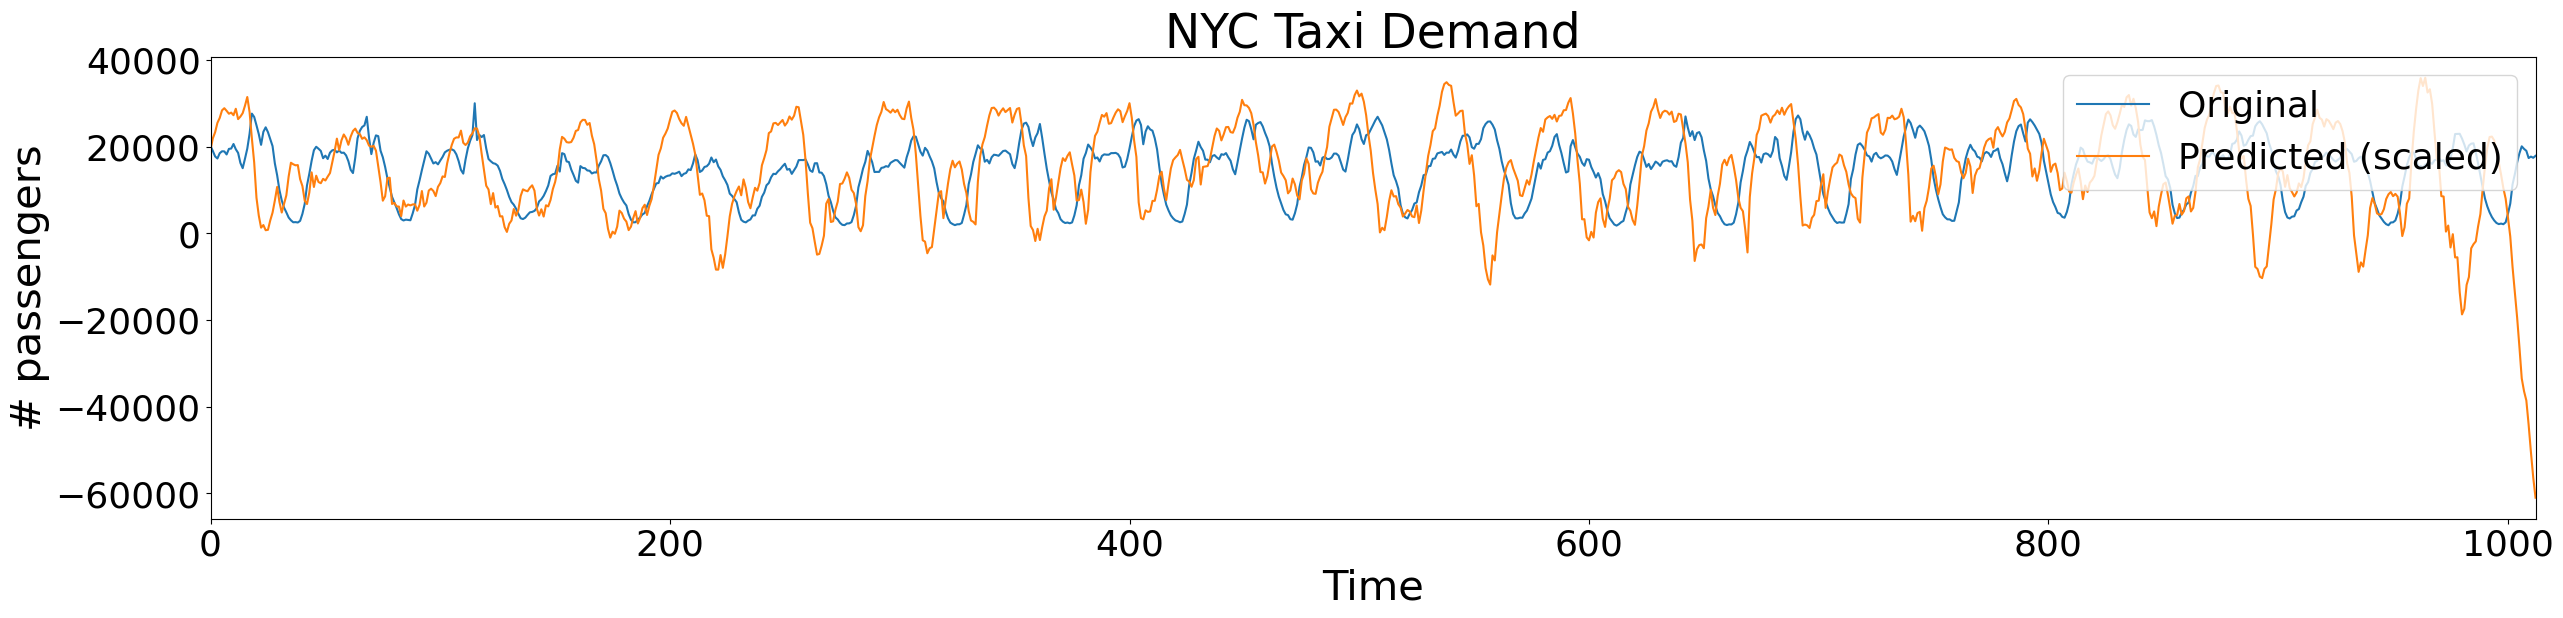

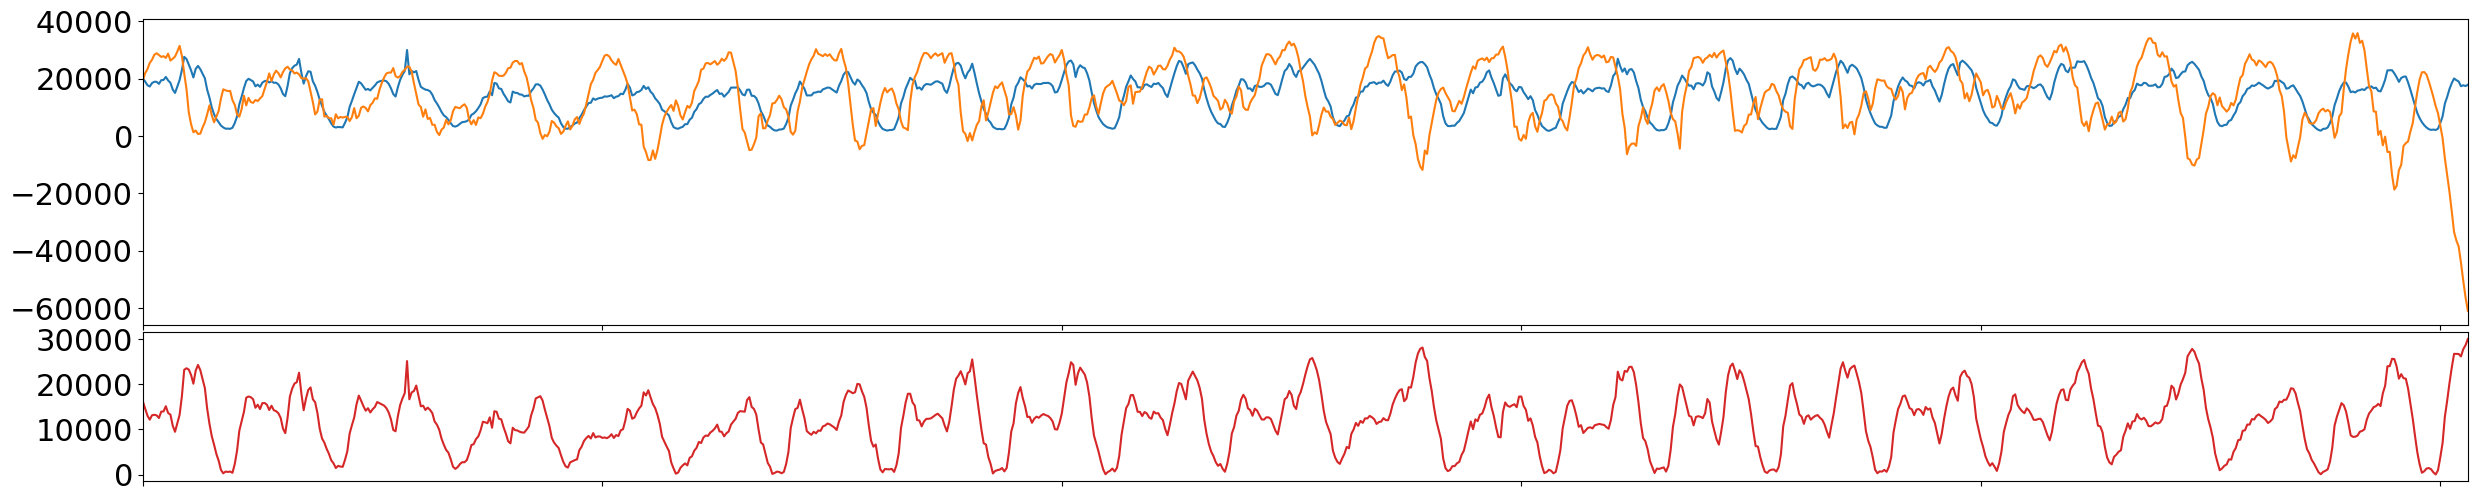

/tmp/ipykernel_76/990148067.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


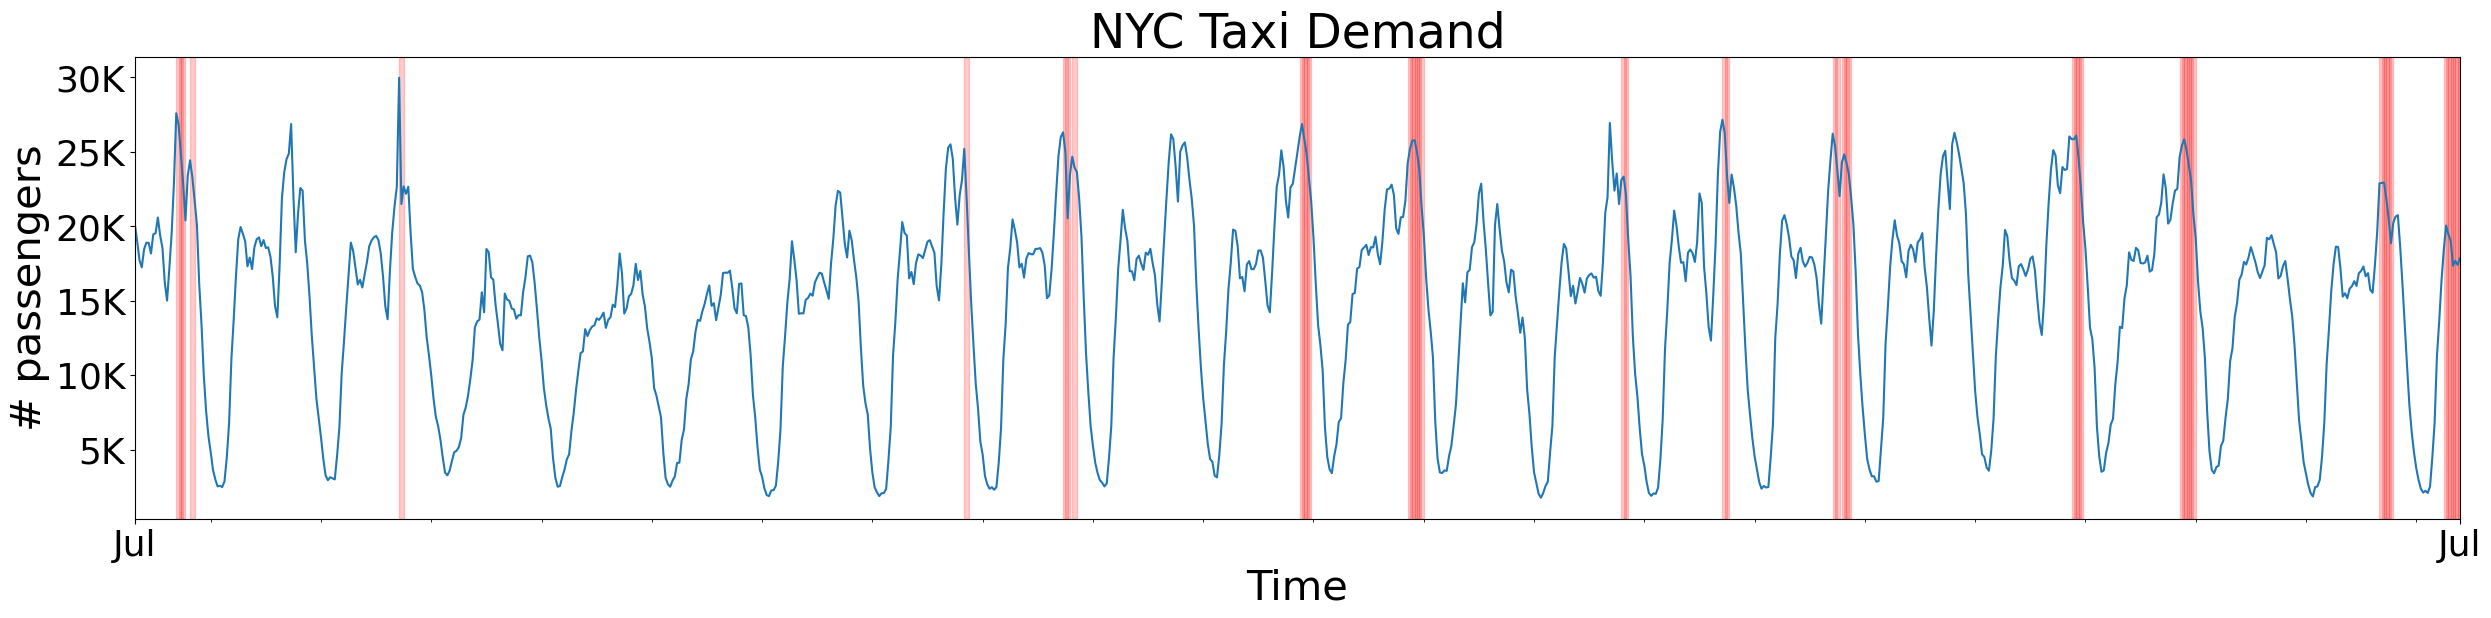

In [36]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# 1. 윈도우 생성 함수
def create_windows(data, window):
    return np.array([data[i:i+window] for i in range(len(data) - window + 1)])

# 2. 모델이 기대하는 윈도우 크기
window_size = 20  

# 3. 시계열 데이터 준비 및 정규화
series = df['value'].values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

X_windowed = create_windows(series_scaled, window_size)
X_windowed = X_windowed.reshape(-1, window_size, 1)

# 4. 예측 수행
y_hat = generator.predict(X_windowed)
y_hat = y_hat.squeeze()  # shape: (samples, window)

# 5. unroll된 시계열로 변환 (예측값과 실제값 모두)
X_true = X_windowed.squeeze()
X_true_unrolled = unroll_ts(X_true)
y_hat_unrolled = unroll_ts(y_hat)

# 역정규화 (inverse scaling)
X_true_unrolled_inv = scaler.inverse_transform(X_true_unrolled.reshape(-1, 1)).flatten()
y_hat_unrolled_inv = scaler.inverse_transform(y_hat_unrolled.reshape(-1, 1)).flatten()

# 6. 이상 점수 계산
score = np.abs(X_true_unrolled_inv - y_hat_unrolled_inv)

# 7. 임계값 기반 이상 탐지
threshold = np.percentile(score, 95)
anomaly_indices = np.where(score > threshold)[0]

# 8. 시각화용 DataFrame 구성
df_cut = df.iloc[window_size - 1:].copy()
df_cut = df_cut.iloc[:len(score)].copy()  # 길이 맞추기
df_cut['score'] = score
df_cut['anomaly'] = 0
df_cut.loc[df_cut.index[anomaly_indices], 'anomaly'] = 1

# 9. 이상 구간 생성
anomaly_df = pd.DataFrame([
    (df_cut['timestamp'].iloc[i], df_cut['timestamp'].iloc[i] + 3600)  # assuming hourly data
    for i in anomaly_indices
], columns=['start', 'end'])

# 10. 시각화 실행
y_hat_unrolled_inv_scaled = y_hat_unrolled_inv * 5 # 학습시에 window_size 100을 썼기에 * 5
plot_ts([X_true_unrolled_inv, y_hat_unrolled_inv_scaled], labels=['Original', 'Predicted (scaled)'])
plot_error([[X_true_unrolled_inv, y_hat_unrolled_inv_scaled], score])
plot(df_cut, anomalies=[anomaly_df])

## 손실함수 시각화

1. Generator & Encoder Loss 시각화
2. Critic X, Z Loss 시각화


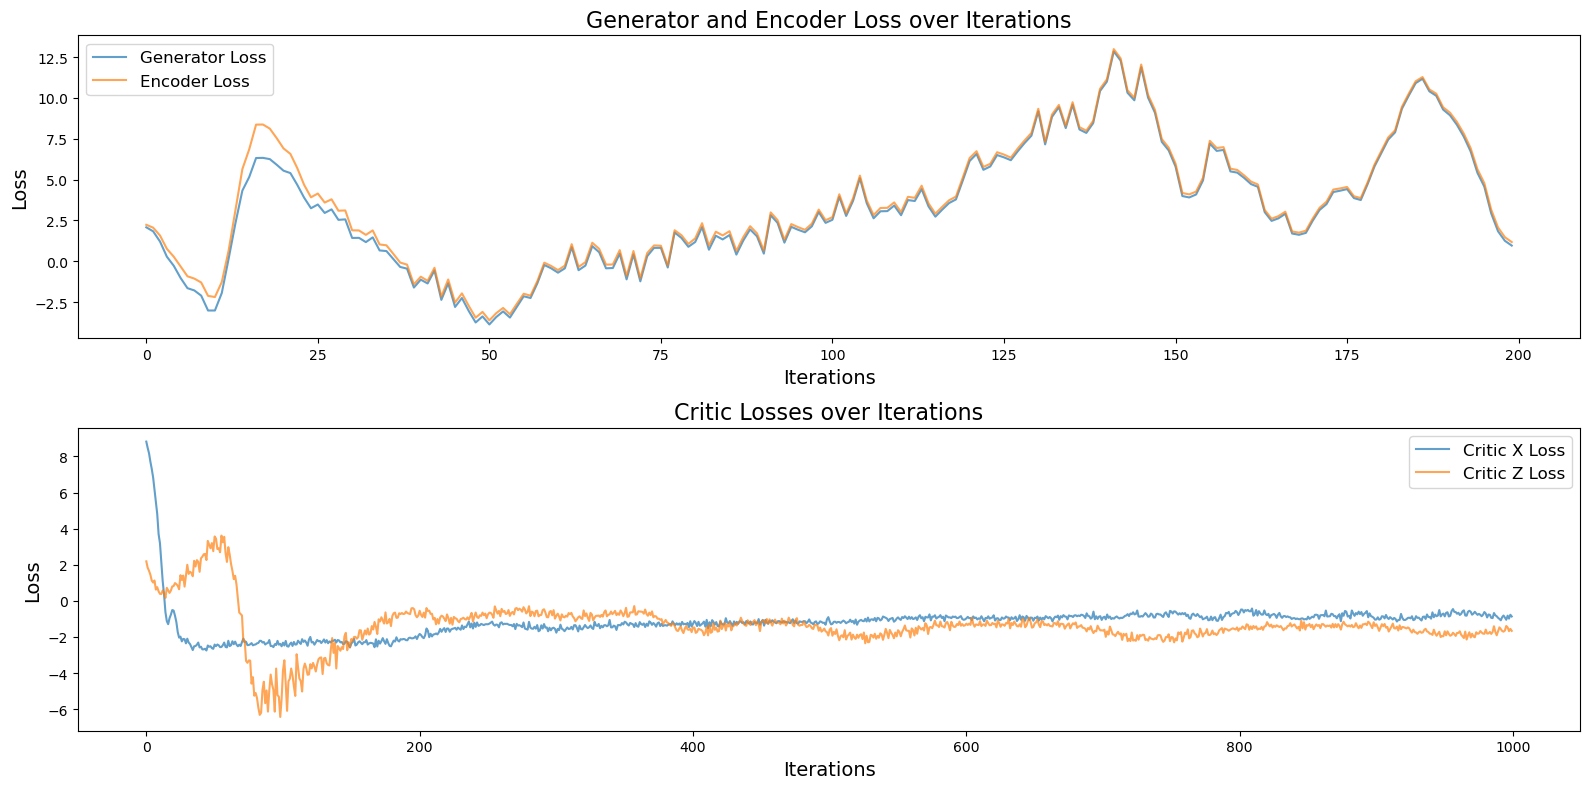

In [37]:
# --- 학습 손실 시각화 ---
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Generator & Encoder Loss 시각화
plt.subplot(2, 1, 1)
plt.plot(epoch_g_loss, label='Generator Loss', alpha=0.7)
plt.plot(epoch_e_loss, label='Encoder Loss', alpha=0.7)
plt.title('Generator and Encoder Loss over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Critic X, Z Loss 시각화
plt.subplot(2, 1, 2)
plt.plot(epoch_cx_loss, label='Critic X Loss', alpha=0.7)
plt.plot(epoch_cz_loss, label='Critic Z Loss', alpha=0.7)
plt.title('Critic Losses over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## 결과 분석

실제 시계열 데이터와 생성된 시계열 데이터를 비교해보면 정상 분포 수준에서 시계열 생성을 잘 할 수 있는 것을 확인
- 전반적으로 주기적인 패턴을 잘 따라가며 재구성된 곡선이 실제 시계열의 추세를 잘 반영하고 있음
- 재구성된 시계열은 scaling 처리가 된 것으로 보이며 일부 구간에서 진폭 차이가 존재     

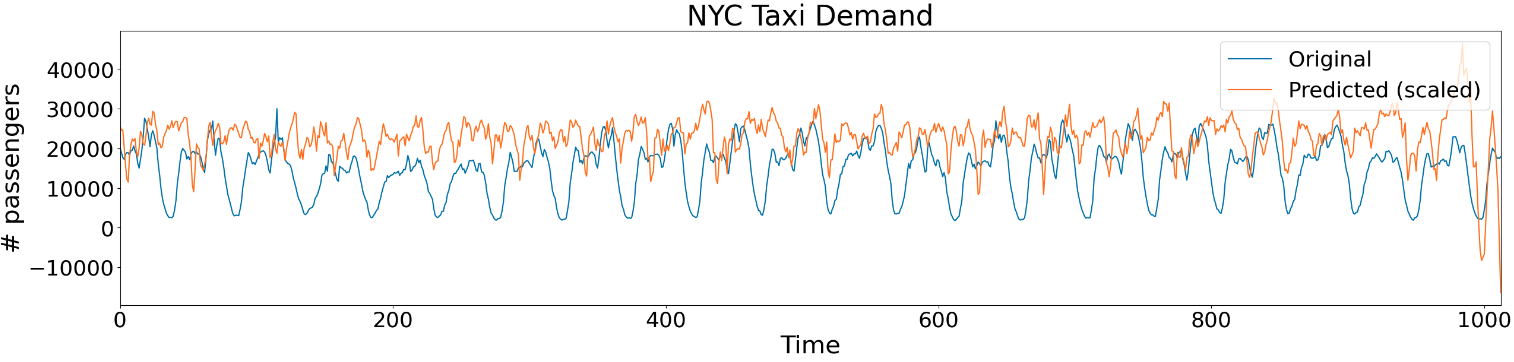
<center>생성 시계열 비교</center>





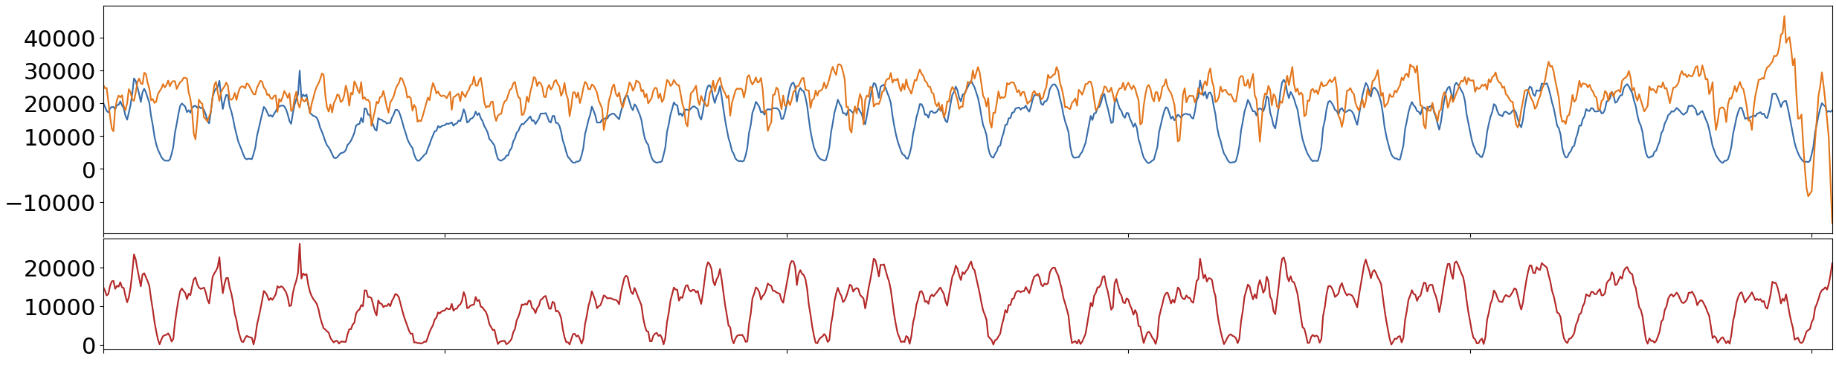
<center>밑에 그림은 생성된 데이터만 표시</center>

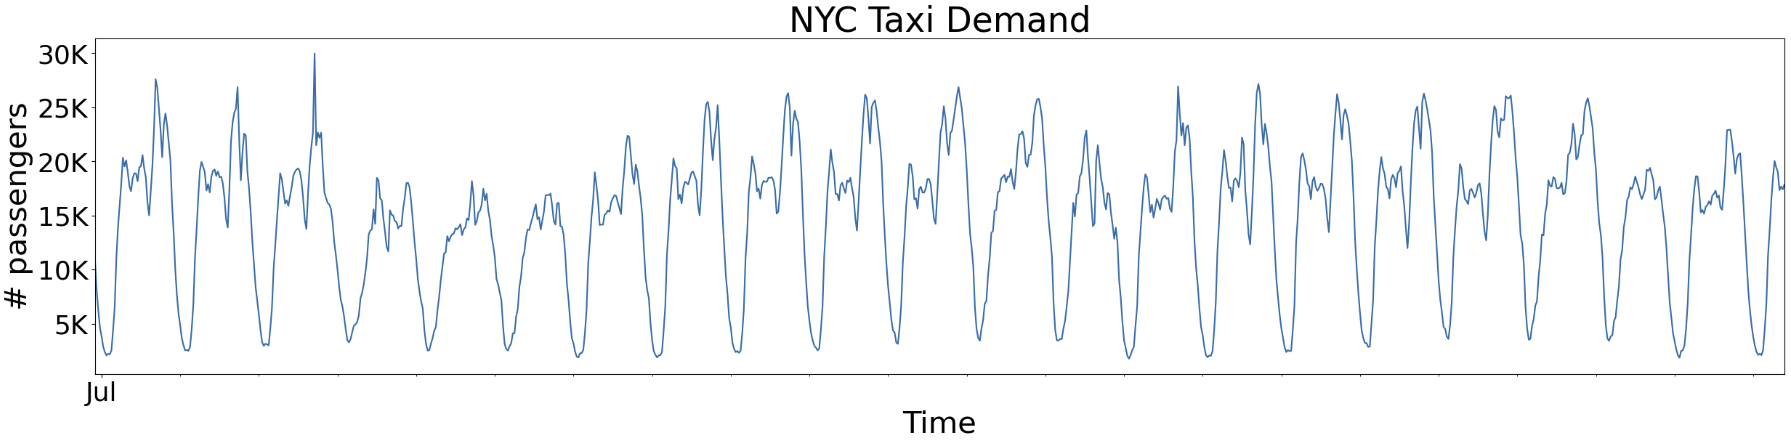
<center>실제 시계열</center>

### 이상 탐지 결과
붉은 색으로 선이 그어져 있는 것이 모델이 이상으로 판단한 부분
- 대부분의 이상치는 급격한 수요 증가 직후나 이상하게 낮은 수요에서 탐지
- 주말, 공휴일, 이벤트 등으로 인한 비정상적인 수요 패턴을 잘 포착한 것으로 해석
- 주기적인 수요에 대해서는 이상 탐지 없이 무시하고 있음    

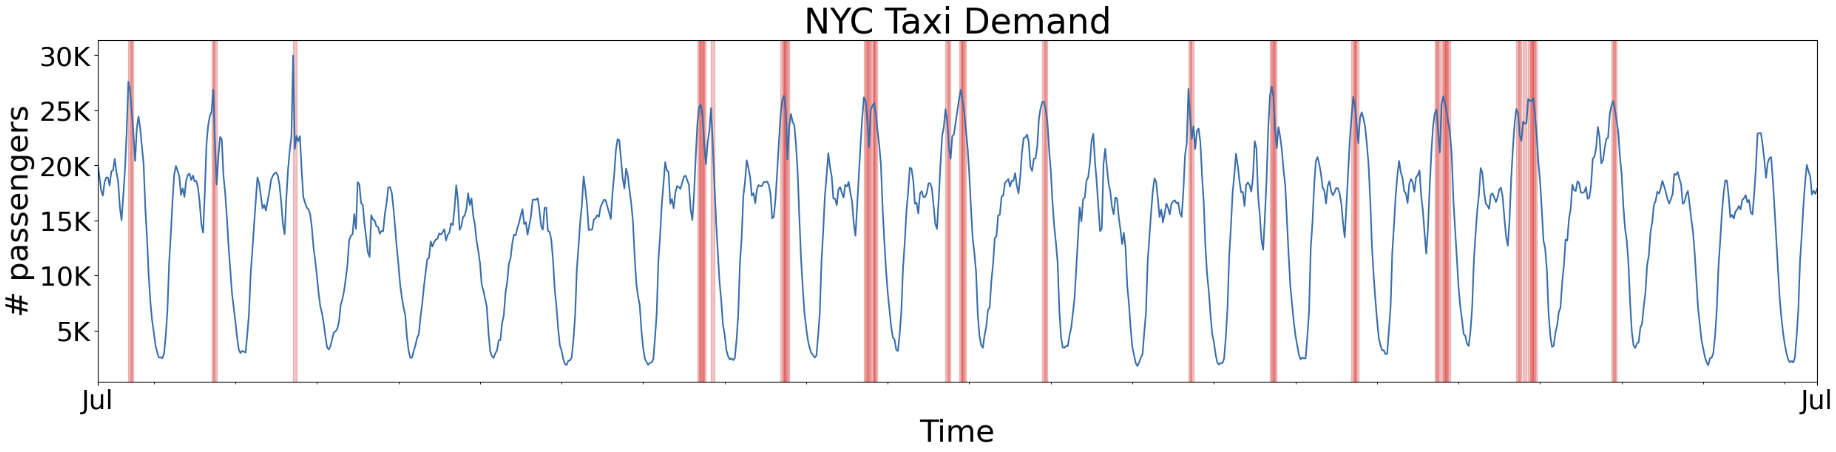
<center>이상 탐지 결과</center>